In [ ]:
! pymol -c ../data/pdb/test/4IRX.pdb -d "ray; png /workdir/4IRX.png, dpi=300; quit"
! pymol -c ../data/pdb/test/4IRX.pdb -d "ray; png /workdir/4IRX.png, dpi=300; quit"
! pymol -c ../data/pdb/test/4IRX.pdb -d "ray; png /workdir/4IRX.png, dpi=300; quit"

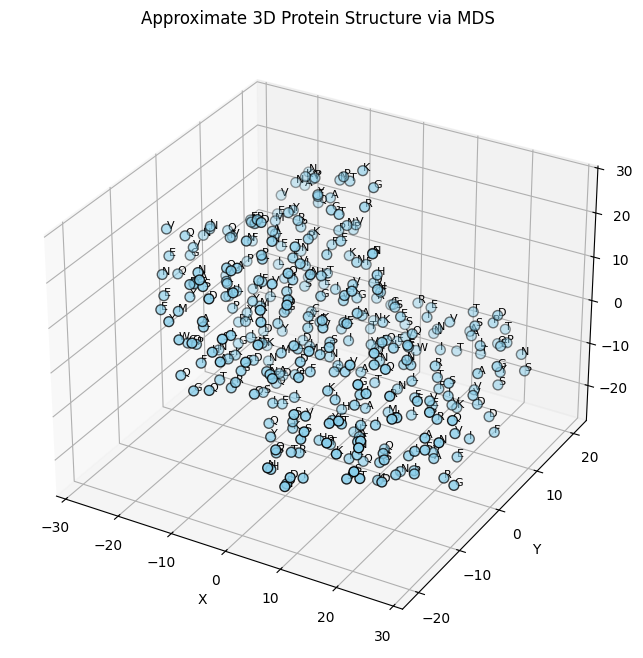

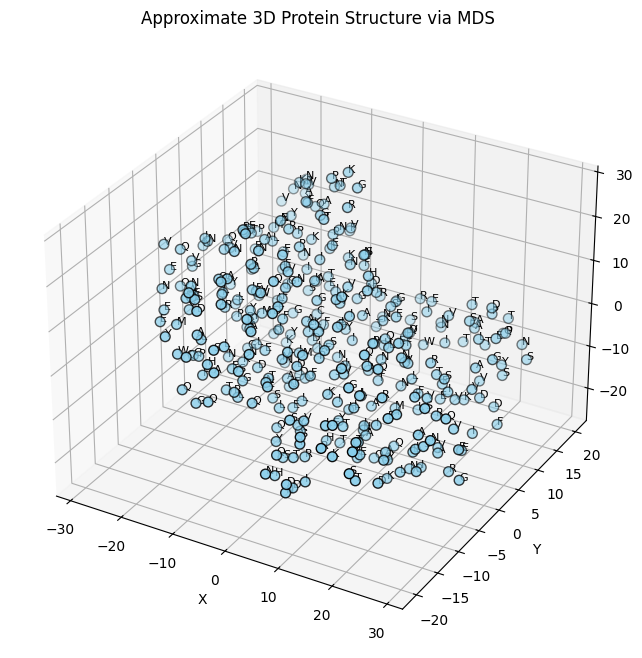

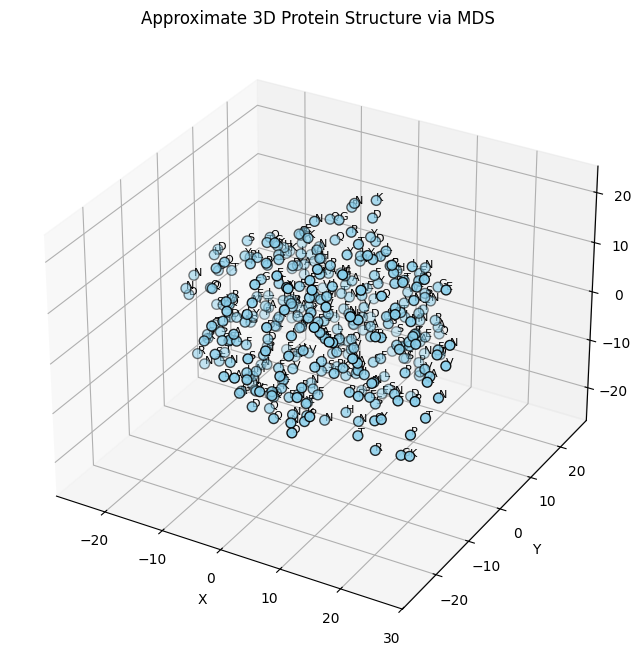

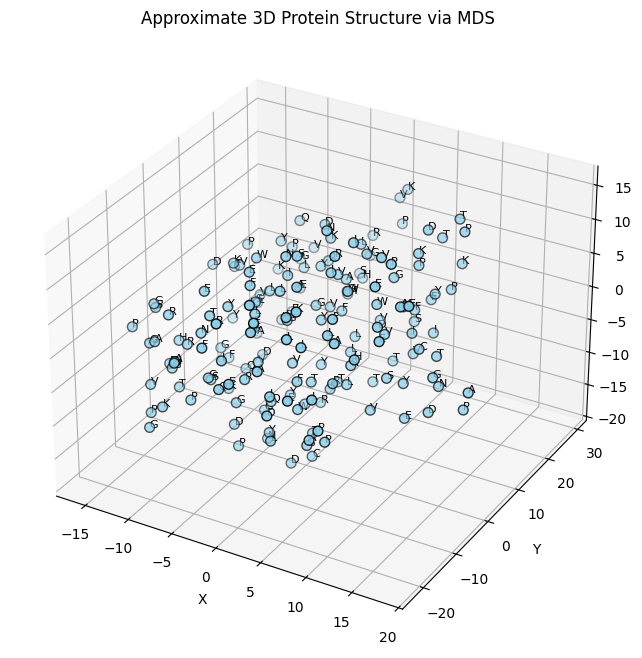

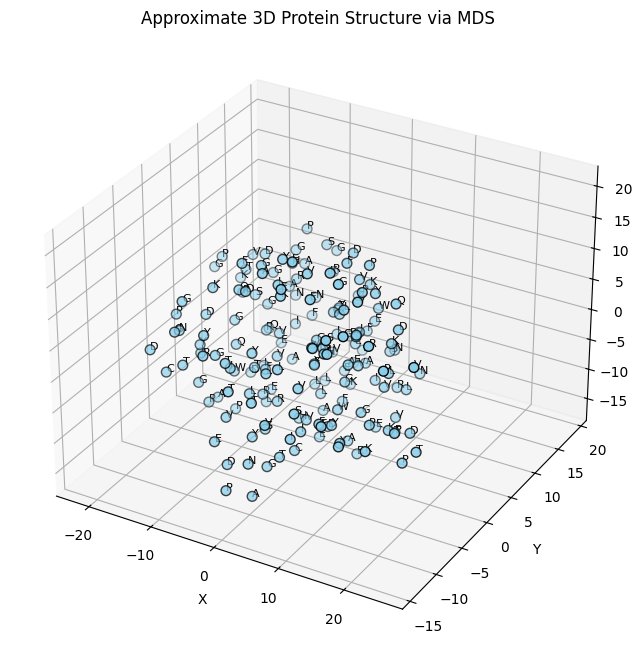

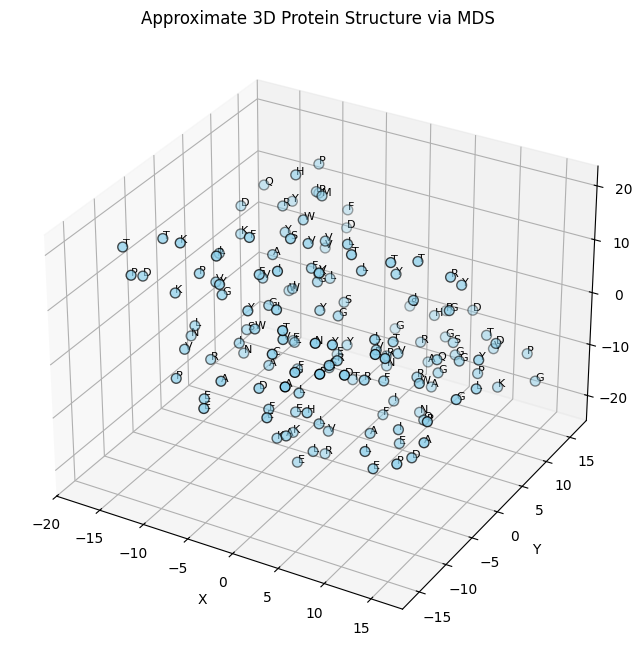

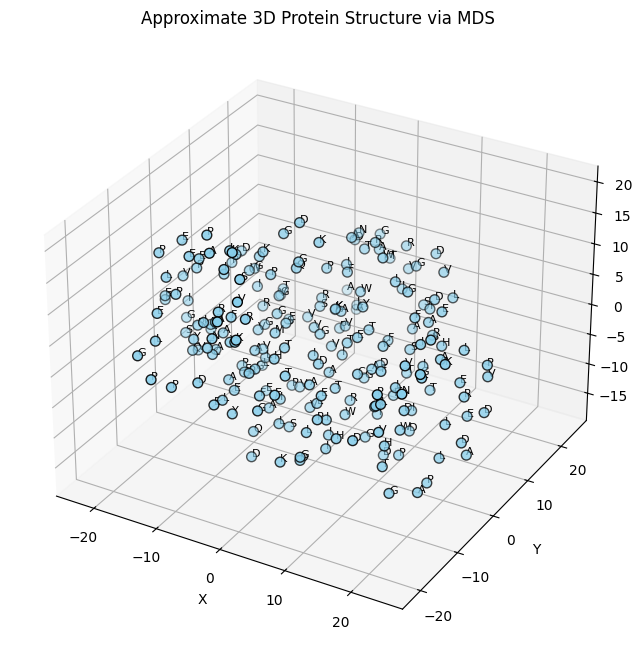

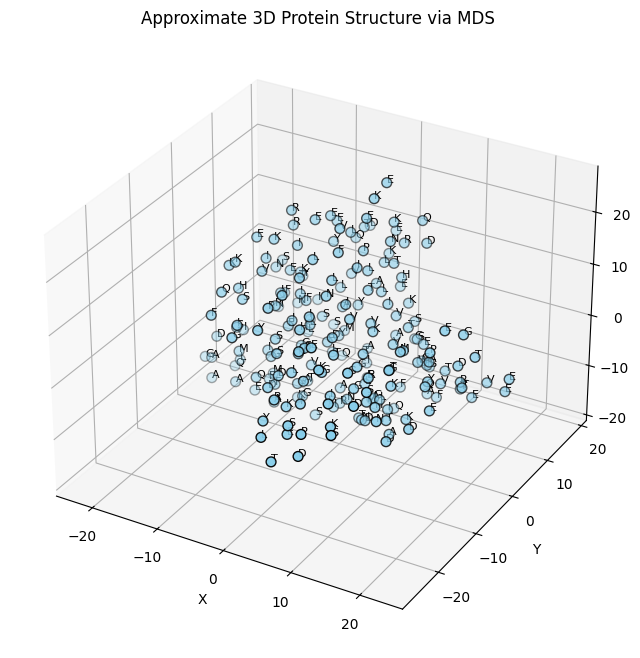

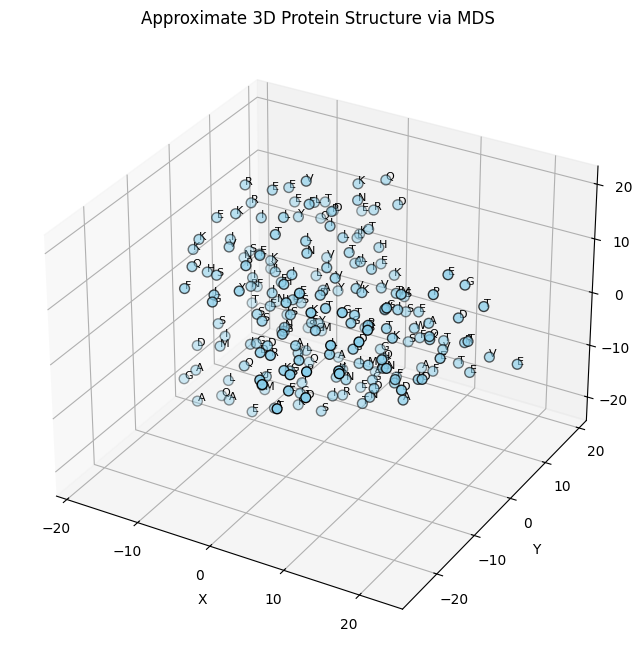

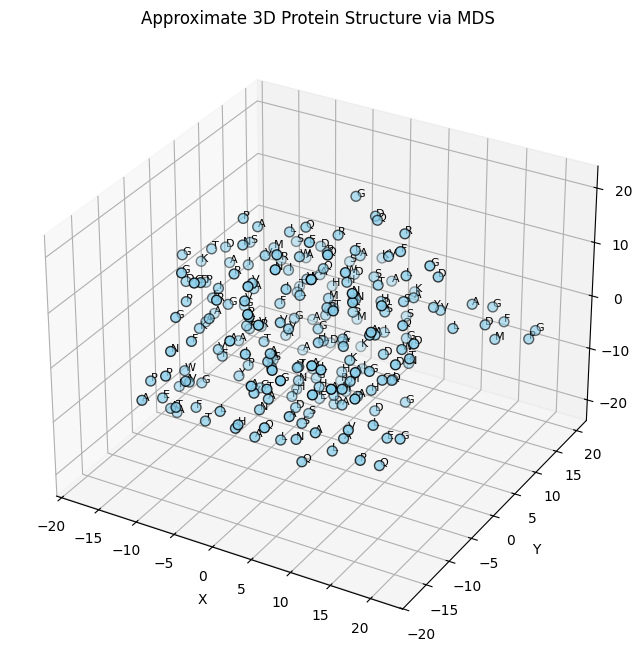

In [29]:
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting

for chain in chains[10:20]:
    mds = MDS(n_components=3, dissimilarity='precomputed', random_state=42)
    coords = mds.fit_transform(chain["distance_matrix"])  # coords is an array of shape (N, 3)
    
    # Visualize the resulting 3D coordinates
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], s=50, c='skyblue', edgecolors='k')
    
    # Optionally, annotate with residue labels (or indices)
    for i, (x, y, z) in enumerate(coords):
        ax.text(x, y, z, chain["sequence"][i], size=8, zorder=1, color='k')
        
    ax.set_title("Approximate 3D Protein Structure via MDS")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.show()

In [24]:
! pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 34.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.5 MB/s eta 0:00:00eta 0:00:01


In [37]:
from Bio.PDB import PDBParser
import nglview as nv

# Parse the PDB file using Biopython.
# parser = PDBParser()
# structure = parser.get_structure("4IRX", "../data/pdb/test/4IRX.pdb")

# Write the structure back to a temporary file if needed, or use nglview's API.
# For simplicity, using nglview directly:
view = nv.show_file("../data/pdb/test/4IRX.pdb")
view

NGLWidget()

In [34]:
! jupyter-nbextension enable nglview --py --sys-prefix

/bin/sh: 1: jupyter-nbextension: not found


In [35]:
! jupyter labextension install @jupyter-widgets/jupyterlab-manager nglview-js-widgets

(Deprecated) Installing extensions with the jupyter labextension install command is now deprecated and will be removed in a future major version of JupyterLab.

Users should manage prebuilt extensions with package managers like pip and conda, and extension authors are encouraged to distribute their extensions as prebuilt packages 
/opt/conda/lib/python3.10/site-packages/jupyterlab/debuglog.py:54: UserWarning: An error occurred.
  warnings.warn("An error occurred.")
/opt/conda/lib/python3.10/site-packages/jupyterlab/debuglog.py:55: UserWarning: ValueError: Please install Node.js and npm before continuing installation. You may be able to install Node.js from your package manager, from conda, or directly from the Node.js website (https://nodejs.org).
  warnings.warn(msg[-1].strip())
/opt/conda/lib/python3.10/site-packages/jupyterlab/debuglog.py:56: UserWarning: See the log file for details: /tmp/jupyterlab-debug-eavuecav.log
  warnings.warn(f"See the log file for details: {log_path!s}")


In [13]:
import os
import esm
import h5py
import torch
import numpy as np
from torch.utils.data import Dataset

class ESM2Dataset(Dataset):
    
    def __init__(
        self,
        h5_file: str,
        mode: str,
        train_mode: str,
        val_mode: str,
        max_length: int,
        sliding_window_step: int,
        use_msa: bool,
    ):
        self.h5_file = h5_file
        self.mode = mode
        self.train_mode = train_mode
        self.val_mode = val_mode
        self.max_length = max_length
        self.sliding_window_step = sliding_window_step
        self.use_msa = use_msa
        self.alphabet = esm.Alphabet.from_architecture("ESM-1")

        self.index_list = []

        with h5py.File(self.h5_file, "r") as file:

            chains_group = file["chains"]

            for key in tqdm(chains_group.keys(), desc=f"Indexing {h5_file}"):
                group = chains_group[key]
                sequence = group.attrs["sequence"].decode("utf-8") if isinstance(group.attrs["sequence"], bytes) else group.attrs["sequence"]
                msa_list = [msa.decode("utf-8") if isinstance(msa, bytes) else msa for msa in group.attrs["msa"]]

                length_sequence = len(sequence)

                if length_sequence > self.max_length:

                    if self.mode == "train":

                        if self.train_mode in ["truncate_seq", "random_crop"]:
                            self.index_list.append((key, 0, self.max_length))

                        else:
                            raise Exception("train_mode should be in ['truncate_seq', 'random_crop']")

                    elif self.mode == "val":

                        if self.val_mode == "truncate_seq":
                            self.index_list.append((key, 0, self.max_length))

                        elif self.val_mode == "sliding_window":
                            start = 0
                            while (start + self.max_length <= length_sequence):
                                self.index_list.append((key, start, self.max_length))
                                start += self.sliding_window_step

                        else:
                            raise Exception("train_mode should be in ['truncate_seq', 'random_crop']")

                    else:
                        raise Exception("mode should be in ['train', 'val']")

                else:
                    self.index_list.append((key, 0, length_sequence))
    
    def __len__(self):
        return len(self.index_list)
    
    def __getitem__(self, index):
        key, start_index, length = self.index_list[index]

        with h5py.File(self.h5_file, "r") as file:

            group = file["chains"][key]
            sequence = group.attrs["sequence"].decode("utf-8") if isinstance(group.attrs["sequence"], bytes) else group.attrs["sequence"]
            msa_list = [msa.decode("utf-8") if isinstance(msa, bytes) else msa for msa in group.attrs["msa"]]

            cmat = group["contact_matrix"][()]
            dmat = group["distance_matrix"][()]
            amat = group["angle_matrix"][()]

        if len(sequence) > self.max_length:

            if self.mode == "train" and self.train_mode == "random_crop":
                start_index = random.randint(0, len(sequence) - self.max_length)

            sequence = sequence[start_index:start_index + self.max_length]
            cmat = cmat[start_index:start_index + self.max_length, start_index:start_index + self.max_length]
            dmat = dmat[start_index:start_index + self.max_length, start_index:start_index + self.max_length]
            amat = amat[start_index:start_index + self.max_length, start_index:start_index + self.max_length]

            if self.use_msa:
                msa_list = [msa[start_index:start_index + self.max_length] for msa in msa_list]

        sequence_tokens = [self.alphabet.cls_idx]

        for amino_acid in sequence:

            sequence_tokens.append(self.alphabet.tok_to_idx.get(amino_acid, self.alphabet.unk_idx))

            if len(sequence) < self.max_length:
                sequence_tokens += [self.alphabet.unk_idx] * pad_length

        sequence_tokens.append(self.alphabet.eos_idx)

        if self.use_msa:

            msa_tokens_list = []

            for msa in msa_list:

                msa_tokens = [self.alphabet.cls_idx]

                for amino_acid in msa:

                    msa_tokens.append(self.alphabet.tok_to_idx.get(amino_acid, self.alphabet.unk_idx))

                    if len(sequence) < self.max_length:
                        msa_tokens += [self.alphabet.unk_idx] * pad_length

                msa_tokens.append(self.alphabet.eos_idx)
                msa_tokens_list.append(msa_tokens)

        padded_cmat = np.zeros((len(sequence) + 2, len(sequence) + 2), dtype=cmat.dtype)
        padded_dmat = np.zeros((len(sequence) + 2, len(sequence) + 2), dtype=dmat.dtype)
        padded_amat = np.zeros((len(sequence) + 2, 2), dtype=amat.dtype)

        padded_cmat[1:len(sequence) + 1, 1:len(sequence) + 1] = cmat
        padded_dmat[1:len(sequence) + 1, 1:len(sequence) + 1] = dmat
        padded_amat[1:len(sequence) + 1, :] = amat

        mask_cmat_dmat = np.ones((len(sequence) + 2, len(sequence) + 2), dtype=bool)
        mask_cmat_dmat[0, :] = False
        mask_cmat_dmat[len(sequence) + 1, :] = False
        mask_cmat_dmat[:, 0] = False
        mask_cmat_dmat[:, len(sequence) + 1] = False
        mask_amat = np.zeros((len(sequence) + 2, ), dtype=bool)
        mask_amat[1:len(sequence) + 1] = True

        sequence_tokens = torch.tensor(sequence_tokens, dtype=torch.long)
        msa_tokens = torch.tensor(msa_tokens_list, dtype=torch.long)
        padded_cmat = torch.from_numpy(padded_cmat)
        padded_dmat = torch.from_numpy(padded_dmat)
        padded_amat = torch.from_numpy(padded_amat)
        mask_cmat_dmat = torch.from_numpy(mask_cmat_dmat)
        mask_amat = torch.from_numpy(mask_amat)

        sample = {
            "sequence_tokens": sequence_tokens,
            "msa_tokens": msa_tokens,
            "contact_map": padded_cmat,
            "distance_map": padded_dmat,
            "angle_map": padded_amat,
            "contact_distance_mask": mask_cmat_dmat,
            "angle_mask": mask_amat,
        }

        return sample


In [14]:
#!/usr/bin/env python3
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join("../src")))
import torch
from torch.utils.data import DataLoader
from utils.utils import load_config
from tqdm import tqdm

# Add the src folder to sys.path.

config = load_config("../src/config.yaml")

train_dataset = ESM2Dataset(
    h5_file="../"+config["train_data_path"],
    max_length=config["dataset"]["max_length"],
    mode="train",
    train_mode="truncate_seq",
    val_mode="truncate_seq",
    sliding_window_step=config["dataset"]["sliding_window_step"],
    use_msa=config["dataset"]["use_msa"],
)

Indexing ../data/processed/train_dataset.h5: 100%|█| 25242/25242 [00:04<00:00, 6


In [16]:
train_dataset[1]

{'sequence_tokens': tensor([32,  4, 15,  5,  8,  8,  4, 10,  5,  4, 15,  4, 20, 13,  4,  8, 11,  4,
         17,  6, 13, 19, 11, 13,  9, 15,  7, 12,  5,  4, 23, 21, 16,  5, 15, 11,
         14,  7,  6, 17, 11,  5,  5, 12,  8, 12, 19, 14, 10,  8, 12,  2]),
 'msa_tokens': tensor([[32, 30, 30,  4, 15,  5,  8,  8,  4, 10,  5,  4, 15,  4, 20, 13,  4,  8,
          11,  4, 17,  6, 13, 19, 11, 13,  9, 15,  7, 12,  5,  4, 23, 21, 16,  5,
          15, 11, 14,  7,  6, 17, 11,  5,  5, 12,  8, 12, 19, 14, 10,  2],
         [32, 11, 13,  4, 15,  5,  8,  8,  4, 10,  5,  4, 15,  4, 20, 13,  4,  8,
          11, 30, 30,  6, 13, 19, 11, 13,  9, 15,  7, 12,  5,  4, 23, 21, 16,  5,
          15, 11, 14,  7,  6, 17, 11,  5,  5, 12,  8, 12, 19, 14, 10,  2],
         [32, 30, 13,  4, 15,  5,  8,  8,  4, 10,  5,  4, 15,  4, 20, 13,  4,  8,
          11,  4, 17,  6, 13, 19, 11, 13,  9, 15,  7, 12,  5,  4, 23, 21, 16,  5,
          15, 11, 14,  7,  6, 17, 11,  5,  5, 12,  8, 12, 19, 14, 10,  2],
         [32,

In [16]:
sample = train_dataset[5]
len(sample['msa_tokens']), sample

(4,
 {'ref_tokens': tensor([32,  4, 15,  5,  8,  8,  4, 10,  5,  4, 15,  4, 20, 13,  4,  8, 11,  4,
          17,  6, 13, 19, 11, 13,  9, 15,  7, 12,  5,  4, 23, 21, 16,  5, 15, 11,
          14,  7,  6, 17, 11,  5,  5, 12,  8, 12, 19, 14, 10,  8, 12,  2]),
  'msa_tokens': tensor([[32,  4, 15,  5,  8,  8,  4, 10,  5,  4, 15,  4, 20, 13,  4,  8, 11,  4,
           17,  6, 13, 19, 11, 13,  9, 15,  7, 12,  5,  4, 23, 21, 16,  5, 15, 11,
           14,  7,  6, 17, 11,  5,  5, 12,  8, 12, 19, 14, 10,  8, 12,  2],
          [32,  4, 15,  5,  8,  8, 24, 10,  5,  4, 15,  4, 20, 13,  4,  8, 11,  4,
           17,  6, 13, 19, 11, 13,  9, 15,  7, 12,  5,  4, 23, 21, 16,  5, 15, 11,
           14,  7,  6, 17, 11,  5,  5, 12,  8, 12, 19, 14, 10,  8, 12,  2],
          [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
            1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
            1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
  

In [ ]:
        with h5py.File(self.h5_file, "r") as file:
            chains_group = file["chains"]
            for key in tqdm(chains_group.keys(), desc=f"Indexing {h5_file}"):
                group = chains_group[key]
                sequence = group.attrs["sequence"].decode("utf-8") if isinstance(seq, bytes) else group.attrs["sequence"]
                grp["target_matrix"][()]

In [ ]:
import h5py
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join("../src")))
from utils.utils import load_config

config = load_config("../src/config.yaml")

with h5py.File("../"+config["val_data_path"], 'r') as f:
    for chain in f["chains"]:
        sequence = f["chains"][chain].attrs['sequence']
        msa = f["chains"][chain].attrs['msa']
        print("sequence length: ", len(sequence))
        print(sequence)
        print(msa)
        print("msa shape: ", msa.shape)
        print("contact_matrix shape: ", f["chains"][chain]["contact_matrix"].shape)
        print("distance_matrix shape: ", f["chains"][chain]["distance_matrix"].shape)
        print("angle_matrix shape: ", f["chains"][chain]["angle_matrix"].shape)
        print(" ")

In [8]:
with h5py.File("../"+config["val_data_path"], "r") as file:
    chains_group = file["chains"]
    for key in chains_group.keys():
        group = chains_group[key]
        sequence = group.attrs["sequence"].decode("utf-8") if isinstance(group.attrs["sequence"], bytes) else group.attrs["sequence"]
        print(group.attrs["msa"])
        break

['SLSAAAQACVKKMRDAKVNEACIRTFIAQHVMVSKGETGSIPDSAIMPVDSLDALDSLTIECDNAVLQSTVVLKLNGGLGTGMGLCDAKTLLEVKDGKTFLDFTALQVQYLRQHCSEHLRFMLMDSFNTSASTKSFLKARYPWLYQVFDSEVELMQNQVPKILQDTLEPAAWAENPAYEWAPPGHGDIYTALYGSGKLQELVEQGYRYMFVSNGDNLGATIDKRVLAYMEKEKIDFLMEVCRRTESDKKGGHLARQTVYVKGKDGQPDAEKRVLLLRESAQCPKADMESFQDINKYSFFNTNNLWIRLPVLLETMQEHGGTLPLPVIRNEKTVDSSNSASPKVYQLETAMGAAIAMFESASAIVVPRWRFAPVKTCADLLALRSDAYVVTDDFRLVLDDRCHGHPPVVDLDSAHYKMMNGFEKLVQHGVPSLVECKRVTVKGLVQFGAGNVLTGTVTIENTDSASAFVIPDGAKLNDTTASP']


In [21]:
! apt-get install muscle

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package muscle


In [50]:
import os
import numpy as np
import argparse
import h5py
from Bio.PDB import PDBParser

for pdb in os.listdir("../data/pdb/train"):
    pdb_file = f"../data/pdb/train/{pdb}"
    
    filename = os.path.basename(pdb_file)
    base_filename, _ = os.path.splitext(filename)
    
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure(base_filename, pdb_file)
    if len(structure) > 1:
        print(len(structure))


2
16
80
167
8
16
16
8
2
10
16
25
20
250
16


In [42]:
model = structure[0]

In [49]:
THREE_TO_ONE = {
    "ALA": "A", "ARG": "R", "ASP": "D", "CYS": "C", "CYX": "C",
    "GLN": "Q", "GLU": "E", "GLY": "G", "HIS": "H", "HIE": "H",
    "ILE": "I", "LEU": "L", "LYS": "K", "MET": "M", "ASN": "N",
    "PHE": "F", "PRO": "P", "SEC": "U", "SER": "S", "THR": "T",
    "TRP": "W", "TYR": "Y", "VAL": "V"
}

chains_data = []
# Typically, PDB files have one model. We use the first model.
model = structure[0]
print(len(structure))
for chain in model:
    chain_id = chain.get_id()
    sequence = ""
    ca_coords = []
    
    for residue in chain:
        # Skip hetero atoms, water, etc.
        if residue.id[0] != " ":
            continue
        resname = residue.get_resname().upper()
        one_letter = THREE_TO_ONE.get(resname, "X")
        
        if "CA" in residue:
            ca_coords.append(residue["CA"].get_coord())
            sequence += one_letter
    print(sequence)

    # if not ca_coords:
    #     continue

    # # Build distance matrix
    # ca_coords = np.array(ca_coords)
    # diff = ca_coords[:, np.newaxis, :] - ca_coords[np.newaxis, :, :]
    # dist_matrix = np.sqrt(np.sum(diff**2, axis=-1))
    
    # contact_matrix = (dist_matrix < 8.0).astype(int)
    # np.fill_diagonal(contact_matrix, 0)

    # homologs = generate_msa_for_sequence(sequence)

    # chain_data = {
    #     "chain_id": chain_id,
    #     "protein": base_filename,
    #     "sequence": sequence,         # reference
    #     "msa": homologs,             # multiple aligned sequences
    #     "distance_matrix": dist_matrix,
    #     "target_matrix": contact_matrix
    # }
    # chains_data.append(chain_data)

1
TGIIMENVTAFWEEGFGELLEKSFSHLCLVGNPVLKNINLNIEKGEMLAITGSTGSGKTSLLMLILGELEASEGIIKHSGRVSFCSQFSWIMPGTIKENIISGVSYDEYRYKSVVKACQLQQDITKFAEQDNTVLGEGGVTLSGGQRARISLARAVYKDADLYLLDSPFGYLDVFTEEQVFESCVCKLMANKTRILVTSKMEHLRKADKILILHQGSSYFYGTFSELQSLRPDFSSKLMGYDTFDQFTEERRSSILTETLRRFS
TTGIIMENVTAFWEEGFGELLEKSFSHLCLVGNPVLKNINLNIEKGEMLAITGSTGSGKTSLLMLILGELEASEGIIKHSGRVSFCSQFSWIMPGTIKENIISGVSYDEYRYKSVVKACQLQQDITKFAEQDNTVLGEGGVTLSGGQRARISLARAVYKDADLYLLDSPFGYLDVFTEEQVFESCVCKLMANKTRILVTSKMEHLRKADKILILHQGSSYFYGTFSELQSLRPDFSSKLMGYDTFDQFTEERRSSILTETLRRFS
STTGIIMENVTAFWEEGFGELLEKFSHLCLVGNPVLKNINLNIEKGEMLAITGSTGSGKTSLLMLILGELEASEGIIKHSGRVSFCSQFSWIMPGTIKENIISGVSYDEYRYKSVVKACQLQQDITKFAEQDNTVLGEGGVTLSGGQRARISLARAVYKDADLYLLDSPFGYLDVFTEEQVFESCVCKLMANKTRILVTSKMEHLRKADKILILHQGSSYFYGTFSELQSLRPDFSSKLMGYDTFDQFTEERRSSILTETLRRFS
TGIIMENVTAFWEEGFGELLSHLCLVGNPVLKNINLNIEKGEMLAITGSTGSGKTSLLMLILGELEASEGIIKHSGRVSFCSQFSWIMPGTIKENIISGVSYDEYRYKSVVKACQLQQDITKFAEQDNTVLGEGGVTLSGGQRARISLARAVYKDADLYLLDSPFGYLDVFTEEQVFESCVCKLMANKTRILVTSKMEHLR

In [ ]:
len(sequence):  N + 2
len(msa):  N + 2
contact_matrix.shape:  (N + 2, N + 2)
distance_matrix.shape:  (N + 2, N + 2)
angle_matrix.shape:  (N + 2, 2)

In [3]:
import os
import h5py
import numpy as np
import argparse
from tqdm import tqdm

def compute_contact_percentage(h5_file):
    """
    Computes the percentage of residue pairs that are in contact 
    (excluding self-contacts) across all chains in the HDF5 dataset.
    
    Args:
      h5_file (str): Path to the HDF5 file.
      
    Returns:
      float: Percentage of contacts.
    """
    total_contacts = 0
    total_possible = 0

    with h5py.File(h5_file, "r") as f:
        chains_group = f["chains"]
        for chain_key in tqdm(chains_group.keys()):
            group = chains_group[chain_key]
            # Load the contact matrix.
            contact_matrix = group["contact_matrix"][()]
            # Assume contact_matrix is square and binary.
            L = contact_matrix.shape[0]
            # Exclude diagonal elements (self-contacts)
            # Total possible pairs for a chain = L*(L-1)
            total_possible += L * (L - 1)
            # Sum the contacts. Assuming diagonal is already 0,
            # otherwise, you could subtract np.sum(np.diag(contact_matrix))
            total_contacts += np.sum(contact_matrix)
            
    # Compute the overall contact percentage.
    if total_possible == 0:
        return 0.0
    percent = (total_contacts / total_possible) * 100
    return percent

compute_contact_percentage("../data/processed/train_dataset.h5")

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 25242/25242 [15:37<00:00, 26.93it/s]


2.8634746928992922

In [4]:
compute_contact_percentage("../data/processed/test_dataset.h5")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 873/873 [00:30<00:00, 28.34it/s]


2.8147947194012626